## **Shopify Fall 2021 Data Science Intern Challenge**

### **Code Overview** 

* Question 1 
  + Exploratory Data Analysis 
* Question 2 
  + SQL Queries 




### **Question 1** 

I have decided to carry out this question using R because I find that for pure data analysis R's ```tidyverse``` package is far superior when it comes to exploratory analysis compared to Python's ```Pandas``` package. In my opinion, the R pipelines are much easier to use than ```Pandas```' groupby function, and they have greater functionality as well. I also love to use R for exploratory analysis due to the great visualization package that is ```ggplot2```.


First we need to download all the packages needed to carry out this analysis. For this Analysis we will be using ```tidyverse``` and ```ggplot2``` in R. After we do this we can start to explore our dataset, and see why we first calculated such a large AOV of $3145.13 across the sneaker shops.

In [ ]:
library("tidyverse")
library("ggplot2")

# Read in our Dataset
shopify_dat <- read.csv("/content/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

So, to get the AOV of $3145.13 we simply calculated the average of order_amount without taking any other factors into account, so to correct for this mistake and get more insight into why the average is so high we first need to check the distribution, to see how the values of the transactions are spread out. To do this we can create a boxplot, so it is easier to visualize the distribution as well as check for any outliers that could be skewing the mean, due to the fact that the mean is very sensitive to outliers.

Next, I also think it is a good idea to determine the mean value of orders grouped by total items. This might be a good metric to analyze, because we can determine the average price of individual items in each of these orders, and check to see if the prices of some items are implausible. Once we know the average price of each individual item, it will be easier to compare these values with the average metric that we later come up with to see if it is a plausible metric to describe the average value of the orders across these sneaker shops. 


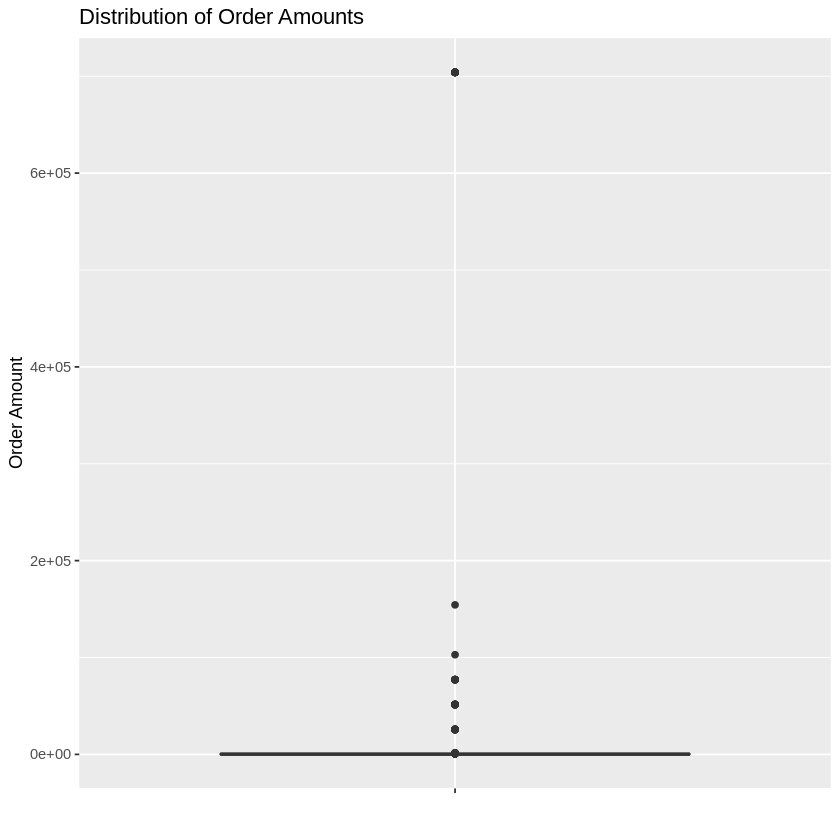

In [ ]:
# Determine Quantiles and IQR
Q_dat <- quantile(shopify_dat$order_amount, probs=c(.25, .5, .75), na.rm = FALSE)
IQR_dat <- IQR(shopify_dat$order_amount)

# Boxplot for Pre-Processed Data Set
plot_outlier <- ggplot(data = shopify_dat, aes(x = "", y = order_amount)) + 
  geom_boxplot() + 
  xlab("") + 
  ylab("Order Amount") + 
  labs(title = "Distribution of Order Amounts")

# Means of Individual Items by Group 
mean_total_item <- shopify_dat %>% 
group_by(total_items) %>% 
summarise(mean = mean(order_amount), max_val = max(order_amount)) %>% 
mutate(ppItem_mean = mean/total_items, ppItem_max = max_val/total_items)

plot_outlier

We can see from this plot, that there are a lot of outliers, and also that y-axis values are greatly separated, which could mean that that there is a very large variance in the value of the orders. So, to look deeper into this we can determine the quartile ranges, and find the outliers. Once we find the outliers, we can then take the average of the data without the outliers for a more accurate AOV.

In [ ]:
mean_total_item

total_items,mean,max_val,ppItem,ppItem_max
<int>,<dbl>,<int>,<dbl>,<dbl>
1,417.3645,25725,417.3645,25725
2,750.2151,51450,375.1075,25725
3,1191.0765,77175,397.0255,25725
4,947.6860,102900,236.9215,25725
5,759.3506,1760,151.8701,352
6,17940.0000,154350,2990.0000,25725
8,1064.0000,1064,133.0000,133
2000,704000.0000,704000,352.0000,352


From our analysis into individual items in the order, we can see that something is not right. Once we group by the total number of items in the order we can see that there is a large disparity between the max value and mean value in these individual groups. Also we can see that the Price Per Item using the Maximum Value is quite expensive at $25725 for usually reasonably priced items such as sneakers. 

We see that the value of $25725 is being repeated, and so this could be due to an error in the dataset that has inaccuratley recorded the price of a specific pair of sneakers. 

To determine if this high max value is due to an error in the dataset, we can calculate the outliers of order amount by group, and then find the average value for each individual item after we remove the outliers. Then, if the average value per item is then similar across the groups we can be more confident in the fact that this large value is due to an error in the dataset, and that it is not representative of the average customer order. 

In [ ]:
# Mean of Individual Items with Removed Outliers 
mean_total_item_no_out <- shopify_dat %>% 
group_by(total_items) %>% 
mutate(lwr = quantile(order_amount, probs = .25), upr = quantile(order_amount, probs = .75), IQR_group = IQR(order_amount)) %>% 
filter(order_amount > (lwr - 1.5*IQR_group) & order_amount < (upr + 1.5*IQR_group)) %>% 
summarise(mean_val = mean(order_amount)) %>% 
mutate(ppItem_mean = mean_val/ total_items)

mean_total_item_no_out


total_items,mean_val,ppItem_mean
<int>,<dbl>,<dbl>
1,150.1793,150.1793
2,300.6334,150.3167
3,455.3929,151.7976
4,592.9517,148.2379
5,750.1333,150.0267
6,888.7500,148.1250


As I suspected, once we remove the outliers we can see the average price per item is similar across all the groups. 


Now that we know there are many outliers that are skewing the data, we should re-visualize the distribution using a boxplot where we use a dataset with the outliers removed. 

50% 
284

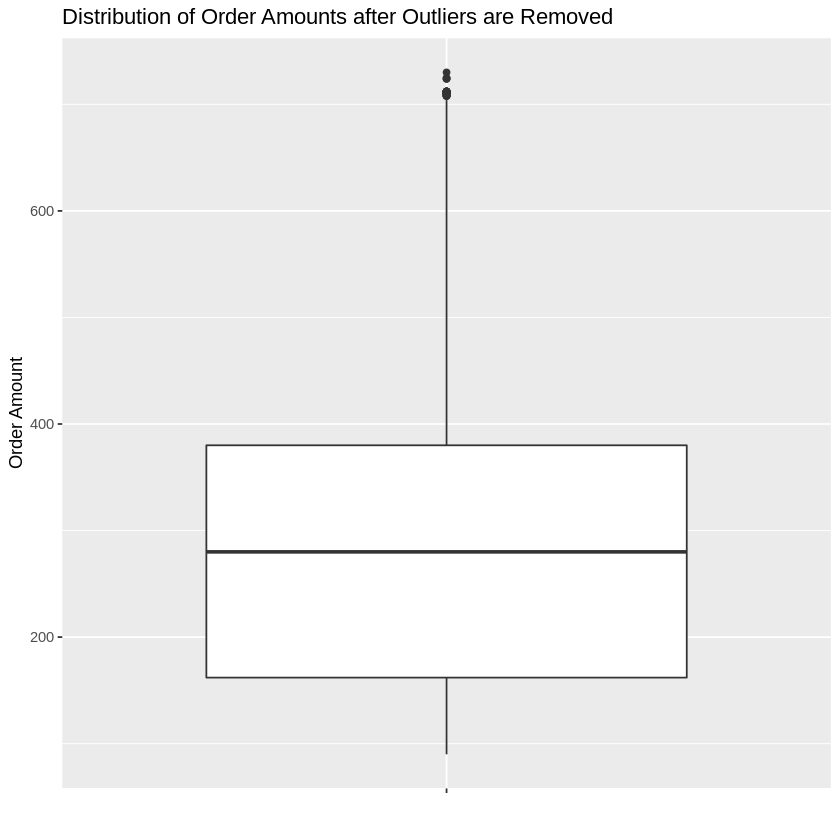

In [ ]:
# Subset of Data without Outliers 
new_amount <- subset(shopify_dat, shopify_dat$order_amount > (Q_dat[1] - 1.5*IQR_dat) & shopify_dat$order_amount < (Q_dat[3] + 1.5*IQR_dat))
ggplot(data = new_amount, aes(x = "", y = order_amount)) + 
  geom_boxplot() + 
  xlab("") + 
  ylab("Order Amount") + 
  labs(title = "Distribution of Order Amounts after Outliers are Removed")

# The median Order Amount of our original Dataset
Q_dat[2]


Now that we removed the outliers, the boxplot looks a lot better. We could probably use the median of the values of the order as a good metric for the value of the average order, since the median is very robust to outliers. For this dataset the median is $284, but now that we have removed the outliers, we could easily take the average of the values of the orders and have it accurately represent the average value of the orders in this shoe shop. Since, the outliers are removed we should prefer to use the mean to determine the average because the it more accurately represents the data due to the fact that it takes all of the values in the dataset into account rather than only being a central measure. 

In [ ]:
mean_order <- mean(new_amount$order_amount)
mean_order

# Validation for new Metric
mean_item <- mean(new_amount$total_items)
mean_item * mean(mean_total_item_no_out$ppItem_mean)

[1] 293.7154

[1] 292.1013

As I stated before we can use the average price of the individual item multiplied by the average number of items in an order and compare it to the metric that we deemed appropriate to represent the average value of the orders across sneaker shops. After computing this value we can see that it is very similar to the metric that we are using, and we can use this information for validation in our metric's accuracy.

So, now we know that the reason for the abnormally large average that we first calculated is due to outliers in the dataset, but we should look into what these outliers are, and discuss the reasons for why they might exist. Without this information we might be overlooking something such as either a bug in the code or a consumer shopping pattern. 

In [ ]:
table(unlist(shopify_dat$total_items))


   1    2    3    4    5    6    8 2000 
1830 1832  941  293   77    9    1   17 

Here we see that most people buy either 1,2, or 3 items per order. 1 person bought 8 items, but 8 items is not nearly as peculiar as 2000 items per order. In 17 orders, there were 2000 items ordered, which is probably driving up the average value. We can do a deep dive into these few orders with 2000 items in order to gain a little bit more insight into what is happening. 

In [ ]:
shopify_dat %>% 
  filter(total_items == 2000)

order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00


From this we can see that the values for shop_id, user_id, order_amount, and total_items are the same for all 17 orders that have 200 items in them. The reason for this error could possibly be because there is a bug in the code that connects to the order database, or maybe the reason for these peculiar orders is because of a person that is buying multiple of the same items, so that they can resell it later for a higher price. Either way, we can see that these 17 orders are not representative of the average purchaser of this store, so when we are determining the average we would not be losing much information regarding the average customer by leaving out these 17 orders. 

So, to reiterate and explicitly answer the sub-questions: 

**1a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.**

There could be many factors that have led us to this erroneous average whether it be the fact that we didn't take in total items into account or the fact that there could be a glitch in reporting accurate prices of the shoes in the dataset. Also, there are 17 orders with 2000 items in them that are skewing the AOV and are not really representative of the average purchase. 

**1b. What metric would you report for this dataset?**

We know that the mean is sensitive to outliers, but it is a very informative measure for the distribution of prices, so what we can do is remove the outliers in the dataset and recalculate the mean in order to get a more accurate value for the AOV.

**1c. What is its value?**

Once we recalculate our average the AOV comes to $293.71

### **Question 2**

**a. How many orders were shipped by Speedy Express in total?**

This is a pretty simple query. We know that we need the number of orders as well as the names of the shippers, so we have to use the ```JOIN``` clause to join the two tables so we can count the number of orders and filter for a specific shipper.

```
SELECT COUNT(*)
FROM Orders
JOIN Shippers ON Orders.ShipperId = Shippers.ShipperId WHERE ShipperName = "Speedy Express";
```

**54** orders were shipped by Speedy Express in total.


**b. What is the last name of the employee with the most orders**

Since this is a more complicated query, I like to use the ```WITH ``` clause in SQL. In this case, it is not technically necessary because we only use the sub-query once in our final query, but I believe that it helps with code readability. 

Basically, we use our subquery to determine the Employee ID and the number of orders associated with each one, which we then use in our final query to filter for the employee ID with the largest number of orders. 

We use the ``` HAVING ``` clause to filter for the greatest number of orders since we employeed ``` GROUP BY ``` after joining the tables Employees and Orders.


```
WITH max_ord AS 
(
SELECT EmployeeID, COUNT(OrderID) as ord_count
FROM Orders
GROUP BY EmployeeID
)
SELECT LastName
FROM Employees
JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID
GROUP BY Employees.EmployeeID, LastName 
HAVING COUNT(*) = (SELECT MAX(ord_count) FROM max_ord);
```

The last name of the employee with the most orders is **Peacock**.


**c.What product was ordered the most by customers in Germany?**

This is the most complicated query, so I found it especially useful to tackle the problem by parts and use the ``` WITH ``` clause. First, I started out by finding all of the orders in Germany. 

Once we write our first sub-query, the next thing that we must do is find the most ordered item in Germany. Since we don't have the Product Name in Orders or Order Details but need the details about the number of orders, we must create another subquery where we join Order Details with German Orders. 

Finally we have the Product ID of the most ordered item in Germany, so then for the final query we simply need to ``` JOIN ``` the Products table with our second sub-query to retrieve the name of the product. 


```
WITH german_customer AS 
( 
SELECT CustomerID 
FROM CUSTOMERS 
WHERE Country = "Germany"
), most_order AS 
( 
SELECT ProductID, SUM(Quantity) as order_num
FROM Orders
JOIN german_customer ON Orders.CustomerID = german_customer.CustomerID 
JOIN OrderDetails on OrderDetails.OrderID = Orders.OrderID
GROUP BY ProductID 
ORDER BY order_num DESC
) 
SELECT ProductName, order_num 
FROM Products
JOIN most_order ON most_order.ProductID = Products.ProductID
LIMIT 1;
```

**Boston Crab Meat** was the most ordered product in Germany. It was ordered **160** times.